A newspaper publishes every year the equivalent of a league table ranking the colleges in a famous academic institution. It builds the table by allocating a score for the class of degree obtained by each graduating student. A first class degree yields $5$ points, a II.1 (upper second) $3$ points, a II.2 (lower second) $2$ points, and a third $1$ point. As the proportions of firsts and other classes vary by subject, these scores are adjusted such that the proportion of firsts become equal across all subjects. The resultant scores are then split by college and summed up to produce the college score in the table. This procedure is said to allow a fairer comparison between the colleges in the institution.

Take $x_i$, $y_i$ as the score per $100$ students for the $i$-th college for $2007$ and $2008$ respectively, for $i = 1 , \dots, 26$. We fit the model
\begin{equation}
    y_i = \alpha + \beta x_i + \epsilon_i, \quad \epsilon_i \overset{\text{iid}}{\sim} N(0, \sigma^2),
\end{equation}
where \alpha$, \beta$ and $\sigma^2$ are unknown parameters.

In [61]:
# @title Data
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import io

data_2007_str = """
Position,   College,        Score,  I,      II.1,   II.2,   III
1,          Agincourt,      306.9,  11,     46,     13,     2
2,          Resolution,     305.0,  27,     50,     33,     6
3,          Erin,           304.8,  23,     75,     30,     4
4,          Duke,           304.8,  25,     61,     26,     10
5,          Colingwood,     299.5,  25,     69,     45,     4
6,          Sovereign,      296.9,  18,     54,     26,     6
7,          Malaya,         296.7,  17,     50,     25,     8
8,          Elizabeth,      296.4,  22,     70,     37,     5
9,          Howe,           289.5,  18,     62,     40,     4
10,         Nelson,         288.1,  15,     49,     28,     7
11,         Fisher,         286.9,  9,      41,     18,     4
12,         Valiant,        286.6,  37,     88,     69,     12
13,         Queen Mary,     286.5,  29,     74,     55,     13
14,         Vanguard,       284.0,  16,     60,     40,     9
15,         Rodney,         283.3,  13,     57,     32,     8
16,         Prince,         282.5,  13,     47,     48,     9
17,         Anson,          281.7,  16,     51,     43,     6
18,         Barham,         281.6,  13,     60,     39,     5
19,         King George,    281.1,  20,     53,     41,     8
20,         Hood,           280.8,  12,     53,     32,     5
21,         Jellicoe,       278.9,  10,     50,     32,     6
22,         Beaty,          274.0,  17,     77,     49,     12
23,         Cunningham,     270.2,  4,      48,     32,     2
24,         Lord,           269.6,  14,     34,     49,     6
25,         Lewin,          264.8,  9,      43,     42,     7
26,         Mountbatten,    247.1,  5,      35,     32,     5
"""

data_2008_str = """
College,        Score,      I,      II.1,   II.2,   III
Agincourt,      288.7,      11,     31,     28,     1
Resolution,     290.0,      20,     58,     43,     3
Erin,           293.5,      19,     58,     39,     2
Duke,           321.4,      24,     68,     18,     3
Colingwood,     305.1,      30,     69,     36,     8
Sovereign,      292.5,      22,     51,     37,     9
Malaya,         303.5,      15,     53,     24,     2
Elizabeth,      321.5,      33,     64,     29,     4
Howe,           293.3,      13,     79,     29,     2
Nelson,         287.6,      11,     50,     22,     3
Fisher,         274.6,      8,      31,     24,     3
Valiant,        303.5,      49,     97,     49,     16
Queen Mary,     309.0,      31,     92,     38,     4
Vanguard,       278.6,      5,      77,     32,     6
Rodney,         299.0,      22,     60,     32,     7
Prince,         295.3,      20,     61,     45,     6
Anson,          285.8,      15,     64,     34,     6
Barham,         289.1,      13,     78,     26,     8
King George,    283.9,      20,     52,     30,     11
Hood,           281.7,      12,     55,     39,     2
Jellicoe,       273.3,      11,     43,     49,     2
Beaty,          262.9,      9,      86,     53,     12
Cunningham,     270.1,      4,      48,     30,     2
Lord,           284.8,      11,     61,     33,     4
Lewin,          292.8,      19,     57,     45,     7
Mountbatten,    271.9,      12,     51,     48,     12
"""

In [62]:
def load_and_merge_data(str_2007, str_2008):
    '''
    Parses CSV strings and merges them into a single DataFrame
    matched by College name.
    '''
    df_07 = pd.read_csv(io.StringIO(str_2007))
    df_08 = pd.read_csv(io.StringIO(str_2008))

    # Trim whitespace from column headers
    df_07.columns = df_07.columns.str.strip()
    df_08.columns = df_08.columns.str.strip()

    # Trim whitespace from College column values
    df_07['College'] = df_07['College'].str.strip()
    df_08['College'] = df_08['College'].str.strip()

    # Merge on 'College' to ensure we pair the correct scores
    merged_df = pd.merge(df_07[['College', 'Score']],
                         df_08[['College', 'Score']],
                         on='College',
                         suffixes=('_07', '_08'))
    return merged_df

def fit_ols_model(x_data, y_data):
    '''
    Fits an Ordinary Least Squares (OLS) regression model.
    Returns the fitted model object.
    '''
    # Add a constant term for the intercept (alpha)
    X_design = sm.add_constant(x_data)

    model = sm.OLS(y_data, X_design).fit()
    return model

def extract_model_statistics(model):
    '''
    Extracts key parameters (alpha, beta, sigma^2) from the model.
    '''
    alpha = model.params['const']
    beta = model.params['Score_07']

    # model.mse_resid is the unbiased estimator for error variance (sigma^2)
    sigma_sq = model.mse_resid
    r_squared = model.rsquared

    return {
        "alpha": alpha,
        "beta": beta,
        "sigma_sq": sigma_sq,
        "r_squared": r_squared
    }

----------------------------------------
Regression: 2008 Score ~ 2007 Score
----------------------------------------
Alpha (Intercept)   : 118.4896
Beta (Slope)        : 0.6021
Sigma^2 (Error Var) : 149.2621
R-squared           : 0.3284
----------------------------------------
                            OLS Regression Results                            
Dep. Variable:               Score_08   R-squared:                       0.328
Model:                            OLS   Adj. R-squared:                  0.300
Method:                 Least Squares   F-statistic:                     11.74
Date:                Wed, 24 Dec 2025   Prob (F-statistic):            0.00221
Time:                        22:29:18   Log-Likelihood:                -100.93
No. Observations:                  26   AIC:                             205.9
Df Residuals:                      24   BIC:                             208.4
Df Model:                           1                                         
Covariance

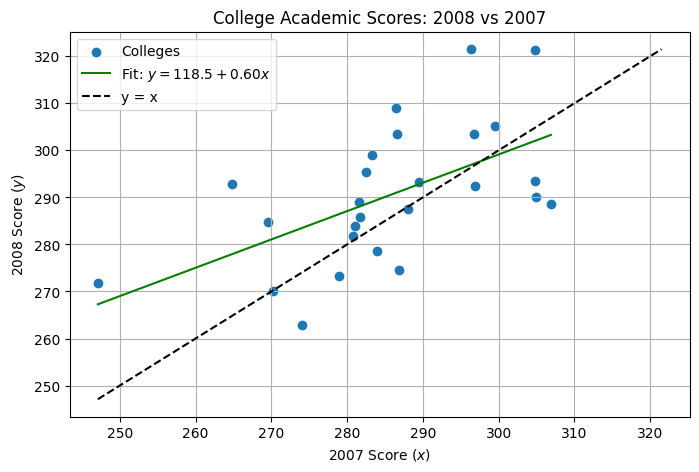

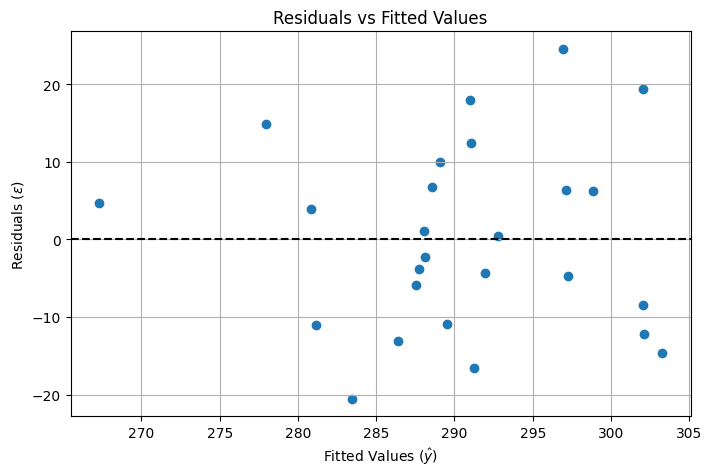

In [63]:
def print_model_report(stats, model_summary):
    '''
    Prints a formatted summary of the regression results.
    '''
    print("-" * 40)
    print("Regression: 2008 Score ~ 2007 Score")
    print("-" * 40)
    print(f"Alpha (Intercept)   : {stats['alpha']:.4f}")
    print(f"Beta (Slope)        : {stats['beta']:.4f}")
    print(f"Sigma^2 (Error Var) : {stats['sigma_sq']:.4f}")
    print(f"R-squared           : {stats['r_squared']:.4f}")
    print("-" * 40)
    print(model_summary)

def plot_regression_fit(x, y, alpha, beta):
    '''
    Plots the data points, the regression line, and the y=x line.
    '''
    plt.figure(figsize=(8, 5))

    # Scatter plot of raw data
    plt.scatter(x, y, label='Colleges')

    # Calculate regression line
    x_grid = np.linspace(x.min(), x.max(), 100)
    y_pred = alpha + beta * x_grid

    # Plot Regression Line
    plt.plot(x_grid, y_pred, label=f'Fit: $y = {alpha:.1f} + {beta:.2f}x$', color='green')

    # Plot y=x reference line
    min_val, max_val = min(x.min(), y.min()), max(x.max(), y.max())
    plt.plot([min_val, max_val], [min_val, max_val], linestyle='--', label='y = x', color='black')

    plt.title('College Academic Scores: 2008 vs 2007')
    plt.xlabel('2007 Score ($x$)')
    plt.ylabel('2008 Score ($y$)')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_residuals(fitted_values, residuals):
    '''
    Plots residuals vs fitted values to check model assumptions.
    '''
    plt.figure(figsize=(8, 5))
    plt.scatter(fitted_values, residuals)
    plt.axhline(0, color='black', linestyle='--')

    plt.title('Residuals vs Fitted Values')
    plt.xlabel('Fitted Values ($\\hat{y}$)')
    plt.ylabel('Residuals ($\\epsilon$)')
    plt.grid(True)
    plt.show()

df = load_and_merge_data(data_2007_str, data_2008_str)

x = df['Score_07']
y = df['Score_08']

model = fit_ols_model(x, y)
stats = extract_model_statistics(model)
print_model_report(stats, model.summary())
plot_regression_fit(x, y, stats['alpha'], stats['beta'])
plot_residuals(model.fittedvalues, model.resid)

The slope $\beta$ is positive, which is expected (a college that performs well one year is likely to perform well the next). However, the slope is significantly less than $1$. This indicates strong regression to the mean. Colleges that had extremely high scores in 2007 tended to have lower scores in 2008 (relative to their previous high). Colleges that had very low scores in 2007 tended to improve in 2008.

The $R^2$ value indicates a weak to moderate fit. The 2007 score explains only a small percentage of the variance in the 2008 score. This implies that knowing a college's score in 2007 does not allow for a precise prediction of their score in 2008. There is a large amount of unexplained variability $\sigma^2$ leading to a large standard error.

The residuals (differences between observed and predicted scores) indicate that there are significant outliers. These large year-on-year swings confirm that the rankings are volatile.

In [64]:
def prepare_data(str_2007, str_2008):
    '''
    Loads, merges, and returns the X (2007) and y (2008) series.
    '''
    df_07 = pd.read_csv(io.StringIO(str_2007))
    df_08 = pd.read_csv(io.StringIO(str_2008))

    df_07.columns = df_07.columns.str.strip()
    df_08.columns = df_08.columns.str.strip()

    df_07['College'] = df_07['College'].str.strip()
    df_08['College'] = df_08['College'].str.strip()

    merged = pd.merge(df_07[['College', 'Score']],
                      df_08[['College', 'Score']],
                      on='College',
                      suffixes=('_07', '_08'))

    return merged['Score_07'], merged['Score_08']

def train_model(x, y):
    '''
    Fits the OLS model and returns the result object.
    '''
    X_design = sm.add_constant(x)
    return sm.OLS(y, X_design).fit()


def get_beta_confidence_interval(model, alpha=0.05):
    '''
    Returns the (lower, upper) CI for the slope parameter.
    '''
    conf_ints = model.conf_int(alpha=alpha)

    lower = conf_ints.loc['Score_07', 0]
    upper = conf_ints.loc['Score_07', 1]
    return lower, upper

def predict_mean_response(model, x_value, alpha=0.05):
    '''
    Calculates the predicted mean score and its confidence interval
    for a specific input x_value.
    '''
    # exog needs to be [1, x_value] because of the intercept
    prediction = model.get_prediction(exog=[1, x_value])
    summary = prediction.summary_frame(alpha=alpha)

    result = {
        "x_input": x_value,
        "predicted_y": summary['mean'][0],
        "ci_lower": summary['mean_ci_lower'][0],
        "ci_upper": summary['mean_ci_upper'][0],
        "width": summary['mean_ci_upper'][0] - summary['mean_ci_lower'][0]
    }
    return result

In [65]:
def print_beta_report(model):
    beta = model.params['Score_07']
    lower, upper = get_beta_confidence_interval(model)

    print("Confidence Interval for Slope (Beta)")
    print("-" * 40)
    print(f"   Estimated Beta : {beta:.4f}")
    print(f"   95% CI         : [{lower:.4f}, {upper:.4f}]")

def print_prediction_comparison(res_mean, res_305):
    print("\nComparison of Predictions")
    print("-" * 40)

    # Report for Mean
    print(f"At x = Mean ({res_mean['x_input']:.2f}):")
    print(f"   Predicted Score: {res_mean['predicted_y']:.4f}")
    print(f"   95% CI         : [{res_mean['ci_lower']:.4f}, {res_mean['ci_upper']:.4f}]")
    print(f"   CI Width       : {res_mean['width']:.4f}")

    # Report for 305
    print(f"At x = 305.0:")
    print(f"   Predicted Score: {res_305['predicted_y']:.4f}")
    print(f"   95% CI         : [{res_305['ci_lower']:.4f}, {res_305['ci_upper']:.4f}]")
    print(f"   CI Width       : {res_305['width']:.4f}")

x, y = prepare_data(data_2007_str, data_2008_str)
model = train_model(x, y)
print_beta_report(model)
res_mean = predict_mean_response(model, x.mean())
res_305 = predict_mean_response(model, 305.0)
print_prediction_comparison(res_mean, res_305)

Confidence Interval for Slope (Beta)
----------------------------------------
   Estimated Beta : 0.6021
   95% CI         : [0.2394, 0.9649]

Comparison of Predictions
----------------------------------------
At x = Mean (285.70):
   Predicted Score: 290.5154
   95% CI         : [285.5703, 295.4605]
   CI Width       : 9.8902
At x = 305.0:
   Predicted Score: 302.1363
   95% CI         : [293.5651, 310.7075]
   CI Width       : 17.1423


When we move from the mean $\bar{x}$ to the specific value $x = 305.0$, the confidence interval shifts in location (the slope $\beta$ is positive) and increases in width (regression pivots around the centroid). This is because the standard error of a predicted mean response in linear regression is given by
\begin{equation}
    SE(\hat{y}) = \sigma \sqrt{\frac{1}{n} + \frac{(x_0 - \bar{x})^2}{S_{xx}}}.
\end{equation}
At the mean $x_0 = \bar{x}$, the second term under the square root is zero and the uncertainty is minimised.

Let $n_{ij}$ be the frequency for college $i$, class $j$ for 2007, for $i = 1, \dots 26$ and $j = 1, \dots, 4$. Assume $(n_{ij})$ independent, multinomial, parameters $n_i$ and $(p_{ij})$, where $\sum_j p_{ij} = 1$ for each $i$ and $n_i$ is defined as $\sum_j n_{ij}$. We now test the hypothesis $H_0 : p_{ij} = \lambda_j$ for each $i, j$ where $(\lambda_j)$ is unknown, and $\sum_{j=1}^4 \lambda_j = 1$.

The null hypothesis states that academic performance is independent of the college. It assumes that the distribution of degree results is the same across the entire university. We will use Pearson's Chi-squared Test with statistic
\begin{equation}
    \chi^2 = \sum_i\sum_j\frac{(O_{ij}−E_{ij})^2}{E_{ij​}}
\end{equation}
and degrees of freedom $(26-1)(4-1) = 75$.

In [70]:
import scipy.stats as stats

def load_contingency_table(data_str):
    '''
    Loads the CSV string into a DataFrame and extracts the numeric matrix.
    '''
    df = pd.read_csv(io.StringIO(data_str))

    df.columns = df.columns.str.strip()
    df['College'] = df['College'].str.strip()

    # Set College as index so we only have the numeric counts
    df.set_index('College', inplace=True)

    return df

def run_chi_squared_test(observed_df):
    '''
    Performs Pearson's Chi-Squared test for independence.
    Returns the test statistic, p-value, degrees of freedom, and frequencies.
    '''
    chi2_stat, p_val, dof, expected = stats.chi2_contingency(observed_df)

    return {
        "chi2_stat": chi2_stat,
        "p_val": p_val,
        "dof": dof,
        "expected": expected
    }

In [81]:
def print_test_results(results):
    print("Pearson's Chi-Squared Test for Homogeneity (2007 Data)")
    print(f"H_0: Proportion of degree classes is the same across all colleges.\n")
    print(f"Chi-Squared Statistic : {results['chi2_stat']:.4f}")
    print(f"Degrees of Freedom    : {results['dof']}")
    print(f"P-Value               : {results['p_val']:.4e}")

observed_counts = load_contingency_table(data_2007_str)
results = run_chi_squared_test(observed_counts)
print_test_results(results)

Pearson's Chi-Squared Test for Homogeneity (2007 Data)
H_0: Proportion of degree classes is the same across all colleges.

Chi-Squared Statistic : 351.7056
Degrees of Freedom    : 125
P-Value               : 1.9448e-23


Since the p-value is less than the standard significance level of $0.05$, we reject the null hypothesis $H_0$. There is statistically significant evidence to suggest that the distribution of degree classes depends on the college. The colleges are not homogeneous, i.e., some colleges produce a significantly different mix of degree classes, beyond what would be expected by random variation alone.


---

1.  Data Presentation

    *   One issue with the data presentation is the subject adjustment. We are not given the raw data by subject, nor the subject mix per college. Performance is confounded by the subjects their students take. While the score attempts to correct for this, we cannot verify if the correction is valid, sufficient or excessive.

    *   The score is a linear combination of categorical outcomes where the weights are entirely arbitrary. Changing these weights could significantly alter the rankings. The score treats ordinal data as interval data which could be questionable.

    *   The colleges vary significantly in size. Smaller sample sizes are subject to higher variance. The table implies that the score is a precise measure of college quality, ignoring the fact that the standard error of the score for a small college is much larger than for a large college.


2.  Linear Regression (2008 vs 2007)
    *   The linear regression analysis $y_i = \alpha + \beta x_i + \epsilon_i$ was appropriate for assessing the stability of the rankings, but it exposes the volitility of the league table.

    *   The slope $\beta$ was significantly less than $1$ which confirms strong regression to the mean. Excellent performance in 2007 was rarely sustained in 2008 and vice versa. This suggests that a large component of a college's yearly score is random noise.

    *   The $R^2$ was very low. Knowing the ranking in 2007 gives very little information about the ranking in 2008.

    *   The 95% confidence interval for a prediction is very wide. Given that the difference between the colleges is often small, these error margins render the specific rank order statistically meaningless.

3.  Chi-Squared Test (Homogeneity)

    *   The Chi-Squared test checked if the distribution of degree classes was homogeneous across colleges. The theory is sound but the inference could be misleading due to confounding variables.

    *   The test was performed on the counts. However, the proportions of degree classes vary by subject. The Chi-Squared test rejects the null hypothesis meaning the colleges are indeed statistically different, but the test cannot provide a reason, e.g., quality or subject mix.
    
    *   The raw counts are not subject-adjusted so the significant result is likely detecting differences in subject composition. Using this result to claim that some colleges perform better than others would be a flaw in causal reasoning.